In [94]:
import random
import itertools
import pandas as pd
from IPython.display import display

import networkx as nx
import matplotlib.pyplot as plt

plt.style.use('default')

# Weights for improved AODV
ALPHA = 0.5   # battery penalty
BETA  = 0.3   # link quality penalty
GAMMA = 0.2   # load penalty


In [95]:
class Node:
    def __init__(self, node_id, battery, load):
        self.id = node_id
        self.battery = battery      # 0..1
        self.load = load            # 0..3
        self.neighbors = {}         # neighbor_id : LQ

    def add_neighbor(self, other, link_quality):
        self.neighbors[other.id] = link_quality

In [96]:
def calculate_node_cost(node, prev_node_id=None):
    # Battery penalty: higher when battery is low
    battery_term = ALPHA * (1 - node.battery)

    # Link quality penalty
    if prev_node_id is None:
        link_term = 0
    else:
        LQ = node.neighbors[prev_node_id]
        link_term = BETA * (1 / LQ)

    # Load (queue length)
    load_term = GAMMA * (node.load / 3)

    return battery_term + link_term + load_term


In [97]:
def path_cost_details(path, nodes):
    rows = []
    prev = None
    total = 0

    for nid in path:
        node = nodes[nid]
        cost = calculate_node_cost(node, prev)
        total += cost

        rows.append({
            "Node": nid,
            "Battery": round(node.battery, 3),
            "Load": node.load,
            "LinkQ": round(node.neighbors.get(prev, 0), 3) if prev else "",
            "Node Cost": round(cost, 4),
            "Accumulated": round(total, 4)
        })

        prev = nid

    return total, pd.DataFrame(rows)


In [98]:
def find_all_paths(nodes, start, end, path=None):
    if path is None:
        path = []
    path = path + [start]

    if start == end:
        return [path]

    paths = []
    for neigh in nodes[start].neighbors:
        if neigh not in path:
            newp = find_all_paths(nodes, neigh, end, path)
            for np in newp:
                paths.append(np)

    return paths


In [99]:
def classic_aodv_best_path(nodes, start, end):
    all_paths = find_all_paths(nodes, start, end)
    all_paths.sort(key=lambda p: len(p))
    return all_paths[0]


In [100]:
def draw_two_diagrams(nodes, classic_path, improved_path):
    G = nx.DiGraph()

    for nid, node in nodes.items():
        G.add_node(nid, battery=node.battery)

    for nid, node in nodes.items():
        for neigh, LQ in node.neighbors.items():
            G.add_edge(nid, neigh, weight=LQ)

    pos = nx.spring_layout(G, seed=42)

    # Color by battery
    node_colors = []
    for nid in G.nodes():
        b = G.nodes[nid]['battery']
        if b > 0.75: node_colors.append("green")
        elif b > 0.5: node_colors.append("yellow")
        elif b > 0.3: node_colors.append("orange")
        else: node_colors.append("red")

    fig, axes = plt.subplots(1, 2, figsize=(16,7))

    # CLASSIC
    ax = axes[0]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=900, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(),
                           edge_color="gray", width=1, alpha=0.4,
                           arrows=True, ax=ax)

    classic_edges = [(classic_path[i], classic_path[i+1]) for i in range(len(classic_path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=classic_edges,
                           edge_color="red", width=3,
                           arrows=True, ax=ax)

    nx.draw_networkx_edge_labels(G, pos,
        edge_labels={(u,v): G.edges[u,v]["weight"] for u,v in G.edges()},
        font_size=8, ax=ax)

    ax.set_title("Classic AODV Best Path (Red)")
    ax.axis("off")

    # IMPROVED
    ax = axes[1]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=900, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    nx.draw_networkx_edges(G, pos, edgelist=G.edges(),
                           edge_color="gray", width=1, alpha=0.4,
                           arrows=True, ax=ax)

    improved_edges = [(improved_path[i], improved_path[i+1]) for i in range(len(improved_path)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=improved_edges,
                           edge_color="blue", width=4,
                           arrows=True, ax=ax)

    nx.draw_networkx_edge_labels(G, pos,
        edge_labels={(u,v): G.edges[u,v]["weight"] for u,v in G.edges()},
        font_size=8, ax=ax)

    ax.set_title("Improved AODV Best Path (Blue)")
    ax.axis("off")

    plt.show()


In [101]:
def compare_protocols(nodes, start, end):
    all_paths = find_all_paths(nodes, start, end)

    print("ALL CANDIDATE PATHS")

    best_cost = float("inf")
    best_path = None
    best_df = None

    for p in all_paths:
        cost, df = path_cost_details(p, nodes)
        print(f"\nPath {p}, Cost = {round(cost,4)}, Hops = {len(p)-1}")
        display(df)

        if cost < best_cost:
            best_cost = cost
            best_path = p
            best_df = df

    classic = classic_aodv_best_path(nodes, start, end)

    print("CLASSIC AODV RESULT")
    print("Best Path:", classic)
    print("Hop Count:", len(classic)-1)

    print("IMPROVED AODV RESULT")
    print("Best Path:", best_path)
    print("Total Cost:", round(best_cost,4))
    display(best_df)

    draw_two_diagrams(nodes, classic, best_path)


In [102]:
def test_case_1():
    nodesA = {
        1: Node(1, 0.90, 0),
        2: Node(2, 0.01, 0),   # dying intermediate hop
        3: Node(3, 0.95, 0),
        4: Node(4, 0.96, 0),
        6: Node(6, 0.92, 0),
    }

    # Shortest path (classic AODV will pick)
    nodesA[1].add_neighbor(nodesA[2], 0.95)
    nodesA[2].add_neighbor(nodesA[6], 0.95)

    # Longer but safe path (improved AODV should pick)
    nodesA[1].add_neighbor(nodesA[3], 0.95)
    nodesA[3].add_neighbor(nodesA[4], 0.95)
    nodesA[4].add_neighbor(nodesA[6], 0.95)

    # Make links bidirectional
    for a in [1,2,3,4,6]:
        for b in nodesA[a].neighbors.keys():
            if a not in nodesA[b].neighbors:
                nodesA[b].add_neighbor(nodesA[a], nodesA[a].neighbors[b])

    print("\nTEST CASE 1 — BATTERY DOMINATES")
    compare_protocols(nodesA, 1, 6)


In [103]:
def test_case_2():
    nodesB = {
        1: Node(1, 0.90, 0),
        4: Node(4, 0.05, 3),
        2: Node(2, 0.90, 0),
        3: Node(3, 0.92, 0),
        6: Node(6, 0.90, 0),
    }

    nodesB[1].add_neighbor(nodesB[4], 0.20)
    nodesB[4].add_neighbor(nodesB[1], 0.20)
    nodesB[4].add_neighbor(nodesB[6], 0.20)
    nodesB[6].add_neighbor(nodesB[4], 0.20)

    for (a,b,lq) in [(1,2,0.95),(2,3,0.95),(3,6,0.95)]:
        nodesB[a].add_neighbor(nodesB[b], lq)
        nodesB[b].add_neighbor(nodesB[a], lq)

    print("\nTEST CASE 2 — CONGESTED RELAY NODE")
    compare_protocols(nodesB, 1, 6)


In [104]:
# ================================
# CELL 11 — TEST CASE 3: LINK QUALITY
# ================================

def test_case_3():
    nodesC = {
        1: Node(1, 0.90, 0),
        4: Node(4, 0.90, 0),
        2: Node(2, 0.90, 0),
        3: Node(3, 0.90, 0),
        6: Node(6, 0.90, 0),
    }

    # Very poor direct link
    nodesC[1].add_neighbor(nodesC[6], 0.05)
    nodesC[6].add_neighbor(nodesC[1], 0.05)

    # Great multi-hop
    for (a,b,lq) in [(1,4,0.95),(4,6,0.95),(1,2,0.95),(2,3,0.95),(3,6,0.95)]:
        nodesC[a].add_neighbor(nodesC[b], lq)
        nodesC[b].add_neighbor(nodesC[a], lq)

    print("\nTEST CASE 3 — LINK QUALITY DOMINATES")
    compare_protocols(nodesC, 1, 6)


In [105]:
def random_case():
    N = 6
    nodes = {}

    for i in range(1, N+1):
        nodes[i] = Node(
            i,
            battery=round(random.uniform(0.30,1.00),2),
            load=random.randint(0,3)
        )

    for i in range(1, N+1):
        for j in range(i+1, N+1):
            if random.random() < 0.6:
                LQ = round(random.uniform(0.1,1.0),2)
                nodes[i].add_neighbor(nodes[j], LQ)
                nodes[j].add_neighbor(nodes[i], LQ)

    print("\nRANDOM TEST CASE")
    compare_protocols(nodes, 1, 6)



TEST CASE 1 — BATTERY DOMINATES
ALL CANDIDATE PATHS

Path [1, 2, 6], Cost = 1.2166, Hops = 2


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,2,0.01,0,0.95,0.8108,0.8608
2,6,0.92,0,0.95,0.3558,1.2166



Path [1, 3, 4, 6], Cost = 1.0824, Hops = 3


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,3,0.95,0,0.95,0.3408,0.3908
2,4,0.96,0,0.95,0.3358,0.7266
3,6,0.92,0,0.95,0.3558,1.0824


CLASSIC AODV RESULT
Best Path: [1, 2, 6]
Hop Count: 2
IMPROVED AODV RESULT
Best Path: [1, 3, 4, 6]
Total Cost: 1.0824


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,3,0.95,0,0.95,0.3408,0.3908
2,4,0.96,0,0.95,0.3358,0.7266
3,6,0.92,0,0.95,0.3558,1.0824


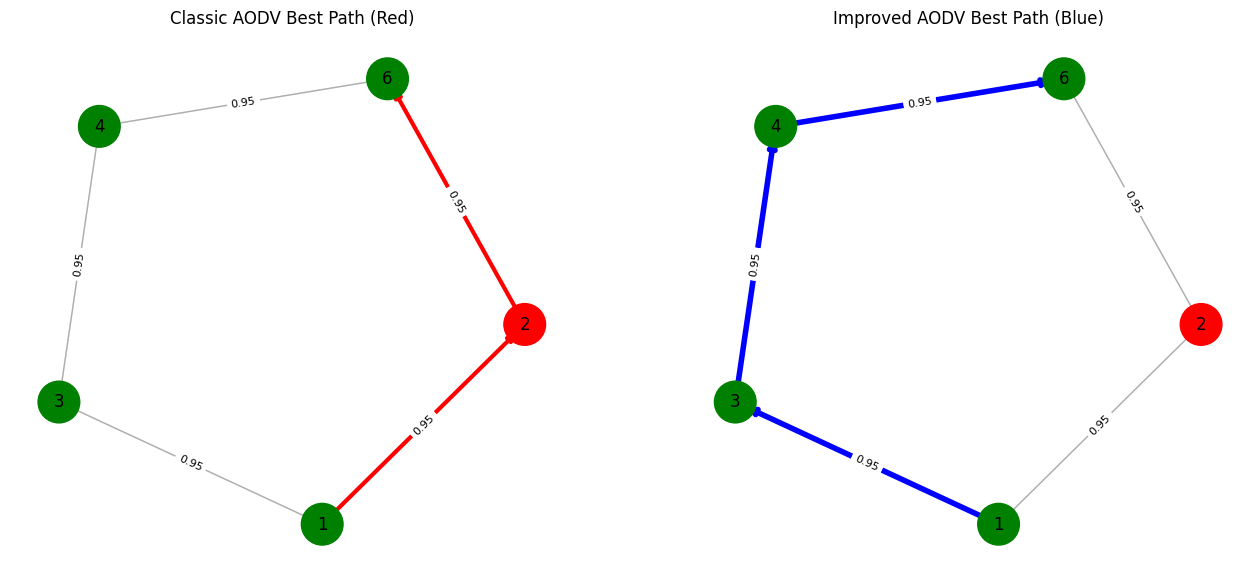


TEST CASE 2 — CONGESTED RELAY NODE
ALL CANDIDATE PATHS

Path [1, 4, 6], Cost = 3.775, Hops = 2


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.050,0.050
1,4,0.05,3,0.2,2.175,2.225
2,6,0.90,0,0.2,1.550,3.775



Path [1, 2, 3, 6], Cost = 1.1374, Hops = 3


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,2,0.90,0,0.95,0.3658,0.4158
2,3,0.92,0,0.95,0.3558,0.7716
3,6,0.90,0,0.95,0.3658,1.1374


CLASSIC AODV RESULT
Best Path: [1, 4, 6]
Hop Count: 2
IMPROVED AODV RESULT
Best Path: [1, 2, 3, 6]
Total Cost: 1.1374


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,0,,0.0500,0.0500
1,2,0.90,0,0.95,0.3658,0.4158
2,3,0.92,0,0.95,0.3558,0.7716
3,6,0.90,0,0.95,0.3658,1.1374


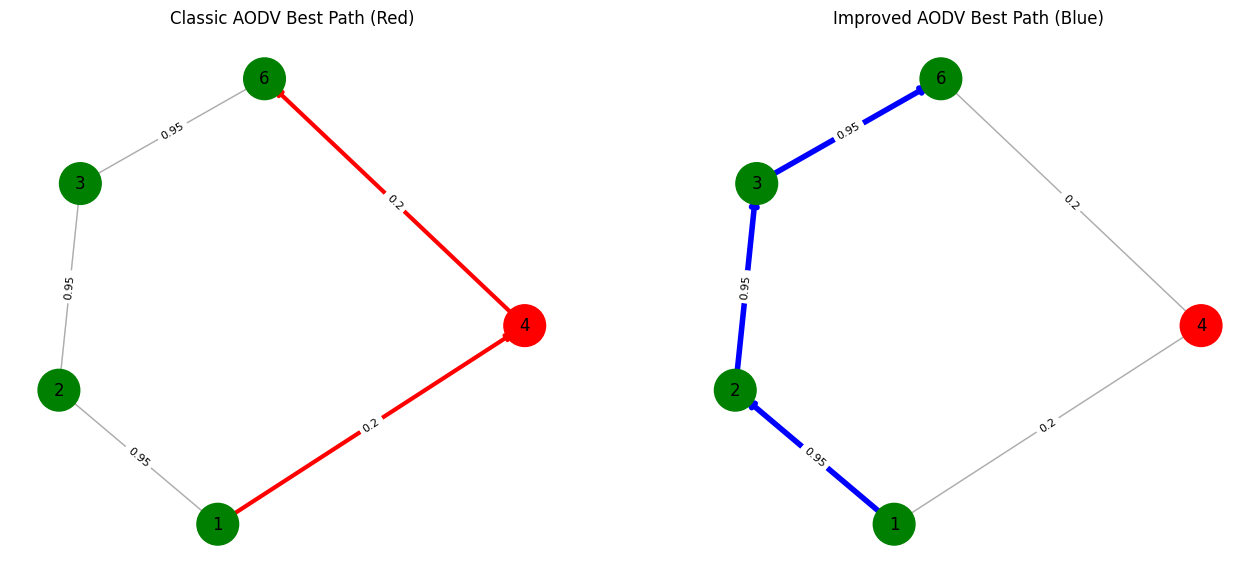


TEST CASE 3 — LINK QUALITY DOMINATES
ALL CANDIDATE PATHS

Path [1, 6], Cost = 6.1, Hops = 1


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.05,0.05
1,6,0.9,0,0.05,6.05,6.10



Path [1, 4, 6], Cost = 0.7816, Hops = 2


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.0500,0.0500
1,4,0.9,0,0.95,0.3658,0.4158
2,6,0.9,0,0.95,0.3658,0.7816



Path [1, 2, 3, 6], Cost = 1.1474, Hops = 3


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.0500,0.0500
1,2,0.9,0,0.95,0.3658,0.4158
2,3,0.9,0,0.95,0.3658,0.7816
3,6,0.9,0,0.95,0.3658,1.1474


CLASSIC AODV RESULT
Best Path: [1, 6]
Hop Count: 1
IMPROVED AODV RESULT
Best Path: [1, 4, 6]
Total Cost: 0.7816


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.9,0,,0.0500,0.0500
1,4,0.9,0,0.95,0.3658,0.4158
2,6,0.9,0,0.95,0.3658,0.7816


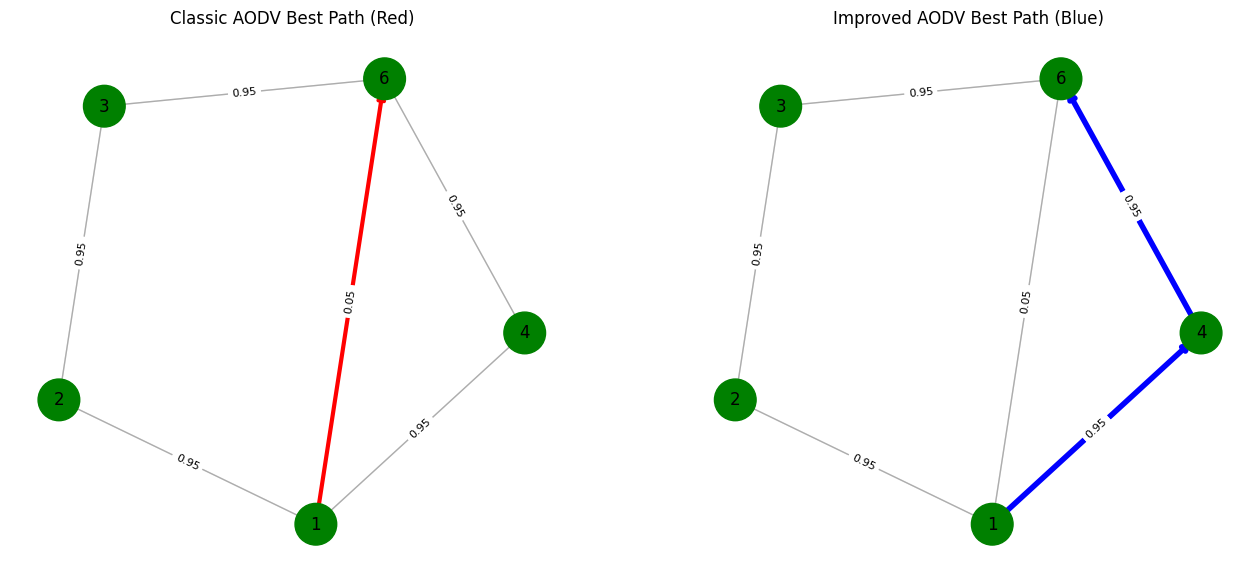


RANDOM TEST CASE
ALL CANDIDATE PATHS

Path [1, 2, 3, 4, 6], Cost = 2.9992, Hops = 4


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,3,,0.2500,0.2500
1,2,0.81,2,0.65,0.6899,0.9399
2,3,0.87,3,0.72,0.6817,1.6215
3,4,0.44,1,0.62,0.8305,2.4521
4,6,0.87,2,0.86,0.5472,2.9992



Path [1, 2, 5, 3, 4, 6], Cost = 4.3812, Hops = 5


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,3,,0.2500,0.2500
1,2,0.81,2,0.65,0.6899,0.9399
2,5,0.42,3,0.31,1.4577,2.3976
3,3,0.87,3,0.88,0.6059,3.0035
4,4,0.44,1,0.62,0.8305,3.8341
5,6,0.87,2,0.86,0.5472,4.3812



Path [1, 3, 4, 6], Cost = 4.2004, Hops = 3


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,3,,0.2500,0.2500
1,3,0.87,3,0.13,2.5727,2.8227
2,4,0.44,1,0.62,0.8305,3.6532
3,6,0.87,2,0.86,0.5472,4.2004


CLASSIC AODV RESULT
Best Path: [1, 3, 4, 6]
Hop Count: 3
IMPROVED AODV RESULT
Best Path: [1, 2, 3, 4, 6]
Total Cost: 2.9992


,Node,Battery,Load,LinkQ,Node Cost,Accumulated
0,1,0.90,3,,0.2500,0.2500
1,2,0.81,2,0.65,0.6899,0.9399
2,3,0.87,3,0.72,0.6817,1.6215
3,4,0.44,1,0.62,0.8305,2.4521
4,6,0.87,2,0.86,0.5472,2.9992


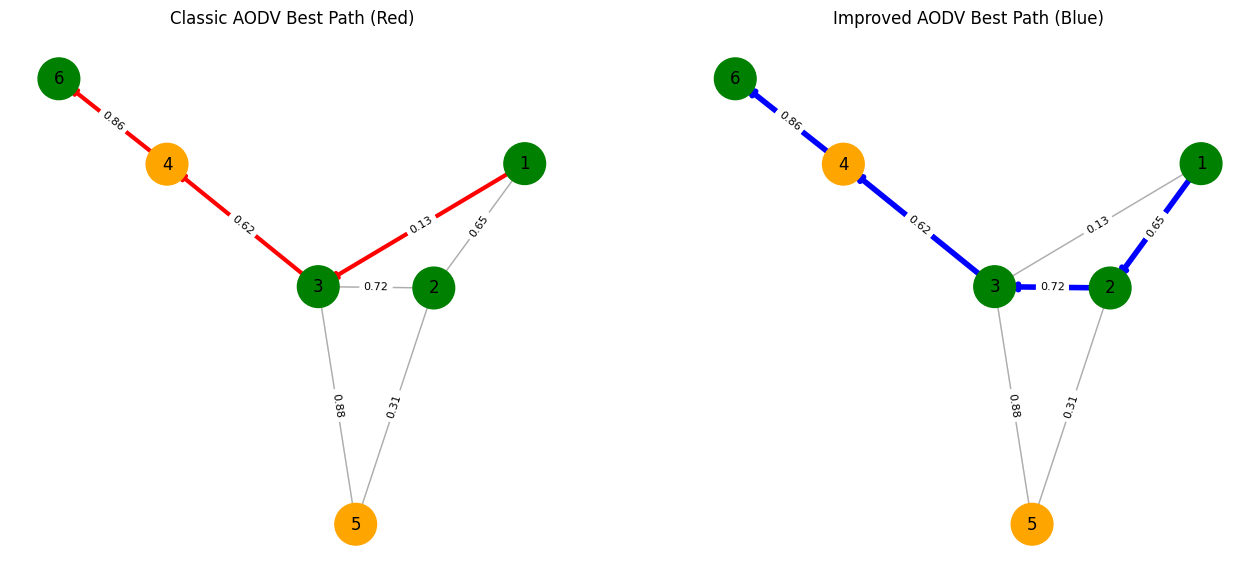

In [116]:
test_case_1()
test_case_2()
test_case_3()
random_case()